# **ETPoF** Homework 4
Annemarie Linnenbank & Tommie Verouden

*5 April 2024*

In [1]:
import pof_piv as piv
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from tqdm import trange

## Part a: Laser Doppler Anemometry (11 points)
### a1) **Particle response time** (2 pts)
The characteristic response time of a particle is $\tau=\frac{2}{9}a^{2}\frac{|{\rho_p - \rho_f}|}{\mu}$. We plot this as a function of the particle radius.

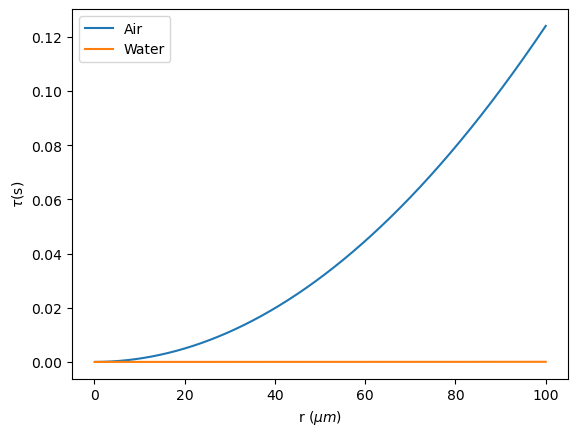

In [ ]:
rho = 1.02 #g/cm^3
rho_tracers = (rho/1000)*(1e6) #kg/m^3
rho_air = 1.225 #kg/m^3
rho_water = 1000 #kg/m^3
mu_air = 1.825e-5
mu_water = 1.0005e-3
rmin = 100e-9
rmax = 100e-6

r = np.linspace(rmin, rmax, 1000)
rho_f = rho_air
mu = mu_air
tau_air = ((2/9)*(r**2)*abs(rho_tracers-rho_f))/mu
beta = 3*rho_f/(rho_f+2*rho_tracers)
St_air = r**2/(3*beta*(mu**2))

rho_f = rho_water
mu = mu_water
tau_water = ((2/9)*(r**2)*abs(rho_tracers-rho_f))/mu
beta = 3*rho_f/(rho_f+2*rho_tracers)
St_water = r**2/(3*beta*(mu**2))

plt.figure()
plt.plot(r*(10**6), tau_air, label='Air')
plt.plot(r*(10**6), tau_water, label='Water')
plt.xlabel('r ($\mu m$)')
plt.ylabel(r'$\tau$(s)')
plt.legend()
plt.show()


In [ ]:
print('For air St=', np.min(St_air), np.max(St_air))
print('For water St=', np.min(St_water), np.max(St_water))

For air St= 0.005558870323634551 5558.870323634552
For water St= 3.374402531645499e-09 0.0033744025316454996


### a2) **Tracer medium** (2 pts)
The particles have the lowest response time in water, which means they accurately follow the flow and are thus more suitable to use in water, although for small radii the response time in air and water is about the same. In air one might wish to use other tracers with a smaller radius or density. Other types of tracer particles include: Tracers with fluorescent dye, which makes the particles easier to see. Tracers with a different refractive index, which influences the scattering cross section or tracers with a reflective coating to improve visibility.

### a3) **Flow velocities** (6 pts)
In order to find the velocity of the particle in the measurement volume, we first find the signal burst. We then analyse the frequency spectrum of the burst and find its maximum. From this we can find the velocity of the particle using:\
$f_D = \frac{2\sin{\Theta/2}}{\lambda_b}v_{p,\bot}$\
We assume the tracer particles have a size of 100$nm$ and the density given in exercise a1, this means that the response time is small enough that we can approximate $v_p=v_{flow}$.\
We use the fft function from a previous homework set.

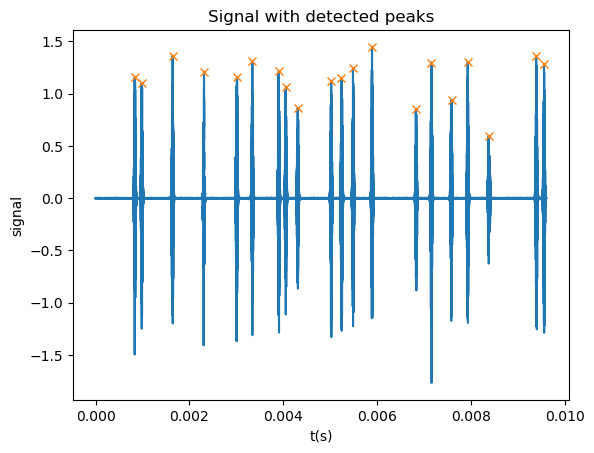

In [ ]:
def bartlett_fft(signal, fs, n_pieces):
    # Cut the signal into n equally-sized pieces
    signal_list = np.split(signal, n_pieces)
    P_list = []

    # Calculate power spectrum of each piece
    for piece in signal_list:
        P_list.append(np.abs(np.fft.fft(piece))**2)

    # Calculate the average power spectrum
    P_av = np.mean(P_list, axis=0)

    # Calculate the frequency array
    f = np.fft.fftfreq(piece.size, 1/fs)
    idx = np.argsort(f)

    # Get only positive frequencies
    f, P_av = f[idx], P_av[idx]

    return f, P_av

# load data and plt
arr = np.loadtxt("LDA-signal.csv",
                 delimiter=",",skiprows=1)
t = arr[:,1]
signal = arr[:,2]

angle = 9*(2*np.pi/360) #angle to radians
lam = 488e-9
width = 600
whalf = 300
peaks, _ = find_peaks(signal, height=0.5, distance=600)

plt.figure()
plt.plot(t, signal)
plt.plot(t[peaks], signal[peaks], "x")
plt.xlabel('t(s)')
plt.ylabel('signal')
plt.title('Signal with detected peaks')
plt.show()

We now take each burst and analyse the frequency spectrum to find the velocities.

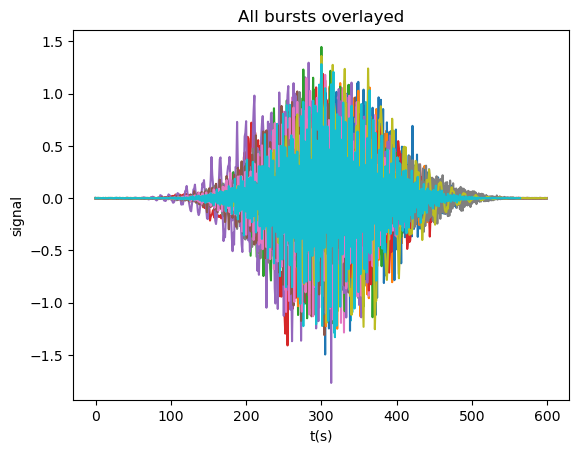

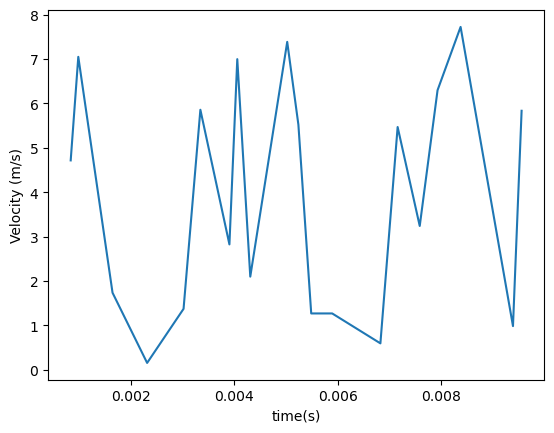

In [ ]:
#take each burst and analyse the frequency spectrum
V = np.zeros(0)
T = np.zeros(0)
for i in peaks:
    #find burst signal
    burst = signal[i-whalf:i+whalf]
    
    plt.figure(4)
    plt.plot(burst)
    plt.title('All bursts overlayed')
    plt.xlabel('t(s)')
    plt.ylabel('signal')
    
    #frequency spectrum analysis
    fs = 1/(t[1]-t[0])     # Hz
    n_pieces = 1
    f, PS = bartlett_fft(burst, fs, n_pieces)
    
    #find most powerful frequency
    ind = np.argmax(PS) #find peak
    fD = abs(f[ind])
    
    
    vp = fD*lam/(2*np.sin(angle/2))
    #v = vp/(1-np.exp(-t[i]/tau_air[0]))
    V = np.append(V, vp)
    T = np.append(T, t[i])
plt.show()
plt.figure(3)
plt.plot(T, V)
plt.xlabel('time(s)')
plt.ylabel('Velocity (m/s)')
plt.show()

As we can see above, the velocity seems to rise and fall in larger peaks. It is perhaps cyclical. We did also notice, that some of the peaks/bursts, were not very pretty, such as the ones below. The first is probably not a burst, while the other might be two bursts. Correcting for these, we can see the velocity plot.

Text(0, 0.5, 'signal')

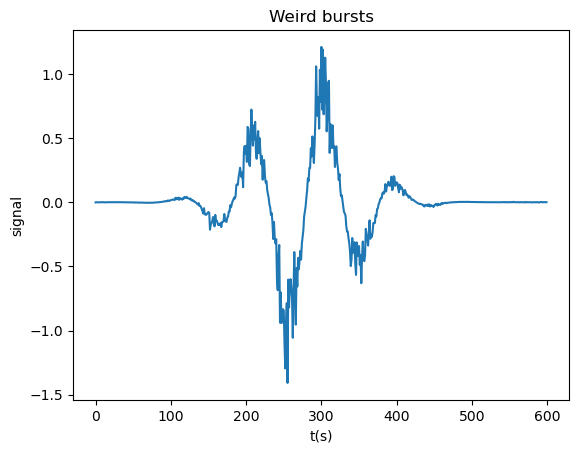

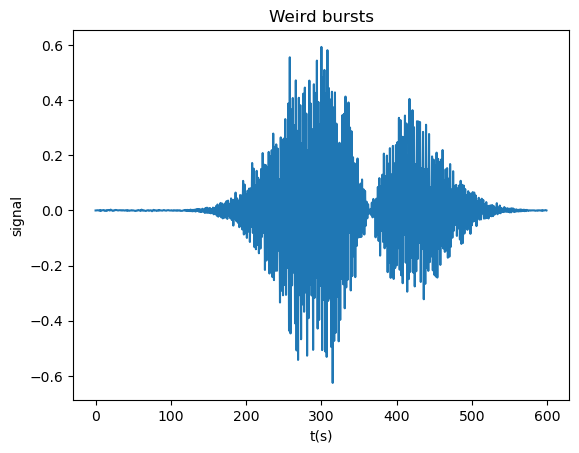

In [ ]:
i = 11556
burst = signal[i-whalf:i+whalf]    
plt.figure()
plt.plot(burst)
plt.title('Weird bursts')
plt.xlabel('t(s)')
plt.ylabel('signal')

i = 41891
burst = signal[i-whalf:i+whalf]    
plt.figure()
plt.plot(burst)
plt.title('Weird bursts')
plt.xlabel('t(s)')
plt.ylabel('signal')

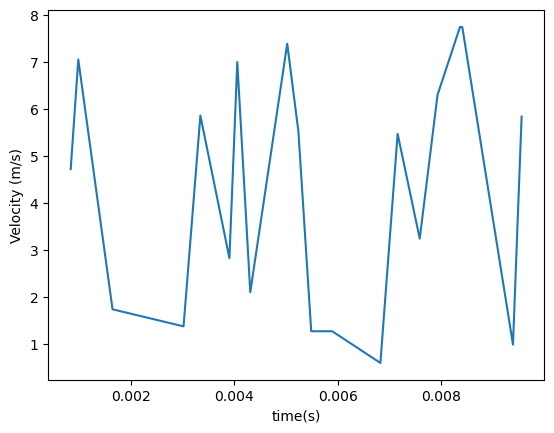

In [ ]:
start = [3860,4597,7909,14781,16410,19221,19982,21240,24814,25896,27137,29166,33830,35498,37636,39361,41715,41956,46660,47496]
stop = [4460,5197, 8509,15381,17010,19821,20582,21840,25414,26496,27737,29766,34430,36098,38236,39961,41956, 42161,47260,48096]

#take each burst and analyse the frequency spectrum
V = np.zeros(0)
T = np.zeros(0)
for i in range(len(start)):
    #find burst signal
    burst = signal[start[i]:stop[i]]
    
    #frequency spectrum analysis
    fs = 1/(t[1]-t[0])     # Hz
    n_pieces = 1
    f, PS = bartlett_fft(burst, fs, n_pieces)
    
    #find most powerful frequency
    ind = np.argmax(PS) #find peak
    fD = abs(f[ind])
    
    
    vp = fD*lam/(2*np.sin(angle/2))
    #v = vp/(1-np.exp(-t[i]/tau_air[0]))
    V = np.append(V, vp)
    T = np.append(T, t[int((start[i]+stop[i])/2)])
plt.show()
plt.figure(3)
plt.plot(T, V)
plt.xlabel('time(s)')
plt.ylabel('Velocity (m/s)')
plt.show()

As we can see, taking into account these stranger bursts does not change the plot much. We still have a seemingly cyclical rise and fall of the velocities in the measurement volume.

### a4) **Measurement volume** (4 pts)
The measurement volume is (according to the handbook):\
$V_0=\frac{4}{3}\pi a_o b_o c_o$, with $a_0 = \frac{d_{w1}/2}{\cos{\Theta/2}}$, $b_0=\frac{d_{w1}}{2}$, $c_0=\frac{d_{w1}/2}{\sin{\Theta/2}}$ and $d_{w1}=\frac{4f\lambda_b}{\pi d_{w0}}$

In [ ]:
#calculation
dw0 = 4e-3
f = 1
dw1 = 4*f*lam/(np.pi*dw0)
a0 = (dw1/2)/(np.cos(angle/2))
b0 = dw1/2
c0 = (dw1/2)/(np.sin(angle/2))
V0 = (4/3)*np.pi*a0*b0*c0
print(f'The measurement volume is {round(V0*(10**9), 5)} mm^3')

The measurement volume is 0.02509 mm^3


## Part b: Particle Image Velocimetry (14 points)
### b1) **Cross-correlation** (2 pts)

Let us first take a look at the images.

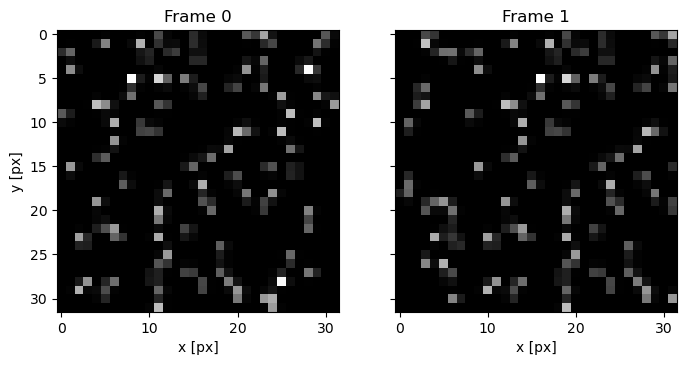

In [2]:
# Load the images
images = piv.read_image_directory('PIVimages/crosscorrelation')

# Display the images
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].imshow(images[0], cmap='gray')
ax[1].imshow(images[1], cmap='gray')

ax[0].set_title('Frame 0')
ax[1].set_title('Frame 1')
ax[0].set_xlabel('x [px]')
ax[0].set_ylabel('y [px]')
ax[1].set_xlabel('x [px]')
ax[1].set_yticklabels([])
plt.show()

The cross-correlation can be calculated using two different functions: directly, or by means of a Fast Fourier Transform. In contrast to what was said in the assignment, according to the documentation of the `scipy.signal.convolve` function, both that function and the `scipy.signal.correlate` automatically determine when each method is fasted (see https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.convolve.html#scipy.signal.convolve).

Let us compare both functions.

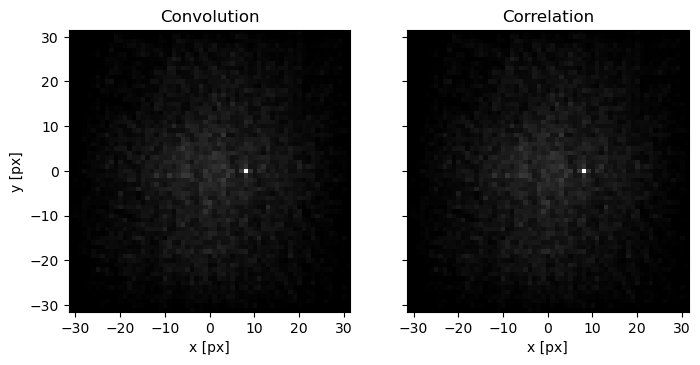

The maximum difference between the convolution and correlation is 4.37e-11, or 8.37e-17 times the maximum value of the correlation.


In [3]:
correlation = piv.correlate_image_pair(images[0], images[1], method='correlate')
convolution = piv.correlate_image_pair(images[0], images[1], method='convolve')

# Define the coordinate system
extent_array = [-images[0].shape[1] + 0.5, images[0].shape[1] - 0.5, -images[0].shape[0] + 0.5,
                 images[0].shape[0] - 0.5] 

fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].imshow(convolution, cmap='gray', interpolation='none',
             extent=extent_array) 
ax[1].imshow(correlation, cmap='gray', interpolation='none',
             extent=extent_array)

for a in ax:
    # Ticks every ten pixels
    a.set_xticks(np.arange(-30, 31, 10))
    a.set_yticks(np.arange(-30, 31, 10))

ax[0].set_title('Convolution')
ax[1].set_title('Correlation')
ax[0].set_xlabel('x [px]')
ax[0].set_ylabel('y [px]')
ax[1].set_xlabel('x [px]')
ax[1].set_yticklabels([])
plt.show()

print(f'The maximum difference between the convolution and correlation is {np.max(np.abs(correlation - convolution)):.2e}, or {np.max(np.abs(correlation - convolution)) / np.max(correlation):.2e} times the maximum value of the correlation.')

The results look identical, but on closer inspection the convolution function outputs floats, while the correlation output integers. Trusting that the correlation function will indeed automatically switch to an FFT-based method when it is faster, we will use it for the rest of the assignment.

Next, we will try to find the displacement by first considering the pixel coordinates of the highest peak (indicated by the red star in the plotbelow), and then performing a subpixel refinement by calculating a correction factor based on fitting a Gaussian through the nearest neighbours (see slides lecture 6):
$$\Delta x = \frac{1}{2}\frac{\ln{(I_{n-1}) - \ln{(I_{n+1})}}}{\ln{(I_{n-1})} + \ln{(I_{n+1})} - 2\ln{(I_n)}}.$$

Using a Gaussian makes sense physically, since the light scattered off a small particle will resemble a Gaussian beam. If we do this in the $y$ direction too, we can make the peak position more accurate, as indicated by green star in the plot below.

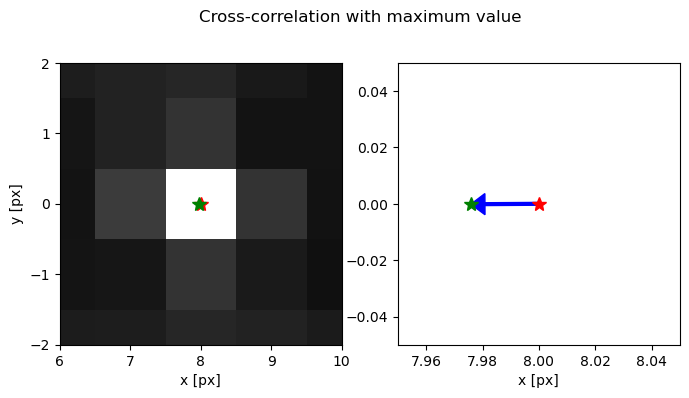

In [4]:
displacement = piv.find_displacement(correlation, subpixel_method=None)
displacement_subpixel = piv.find_displacement(correlation, subpixel_method='gauss_neighbor')

# Plot the cross-correlation with the maximum value
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
for a in ax:
    a.imshow(correlation, cmap='gray', interpolation='none', extent=extent_array)
    a.plot(*displacement[::-1], 'r*', markersize=10)
    a.plot(*displacement_subpixel[::-1], 'g*', markersize=10)
    
    a.set_xlabel('x [px]')

# Zoom in around the maximum value
ax[0].set_xlim(displacement[1] - 2, displacement[1] + 2)
ax[0].set_ylim(displacement[0] - 2, displacement[0] + 2)
ax[0].set_xticks(np.arange(-2, 3, 1) + displacement[1]) 
ax[0].set_yticks(np.arange(-2, 3, 1) + displacement[0])

ax[1].set_xlim(displacement[1] - 0.05, displacement[1] + 0.05)
ax[1].set_ylim(displacement[0] - 0.05, displacement[0] + 0.05)

# Blue arrow
ax[1].arrow(*displacement[::-1], *(displacement_subpixel[::-1] - displacement[::-1]), length_includes_head = True, color='b', head_width=0.0075, head_length=0.005)

fig.suptitle('Cross-correlation with maximum value')
ax[0].set_ylabel('y [px]')

plt.show()

### b2) **PIV solver** (9 pts)

Using the functions from the previous part, we have written a simple PIV solver. The solver is based on the following steps:
1. Divide the images into (identical) interrogation windows of given size.
2. Calculate the cross-correlation between the interrogation windows of two images.
3. Find the displacement by finding the maximum of the cross-correlation.
4. Perform subpixel refinement by fitting a Gaussian through the nearest neighbours.
5. Repeat steps 2-4 for all interrogation windows.
6. Optionally, if calibration data is given, calculate the velocity field by dividing the displacement by the time between the two images and multiplying it by the calibration factor in units of length per pixel.

Below, we demonstrate it using the four examples.

#### Shear flow
Here, we use rectangular windows of size $(32, 64)$ to calculate the displacement field. The arrows (scaled up for visibility) in the plot below indicate the displacement, and the windows are outlined in grey.

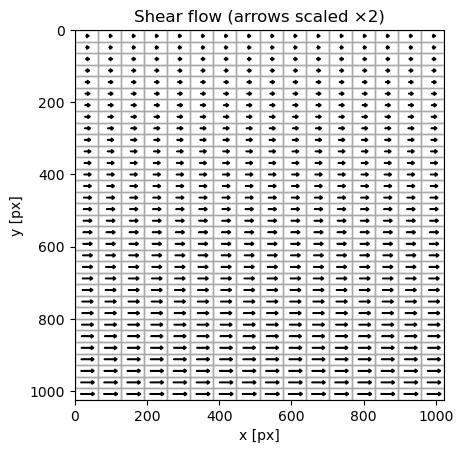

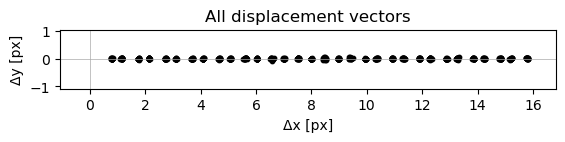

In [5]:
images = piv.read_image_directory('PIVimages/shearflow/')
plot_params = {'arrow_scale':            2,
               'plot_windows':           True,
               'title':                  'Shear flow'}

displacements, coordinates = piv.simple_piv(images, (32, 64), plot=True, plt_flow_params=plot_params, plt_disp_params=plot_params)

We chose rectangular windows because it became clear from the plot of all displacements that the flow is very uniform in the y direction. A window size as small as 2 pixels in the y direction gives correct results (with only slightly larger spread $\Delta y$), but for visualisation purposes, 32 pixels looked best.

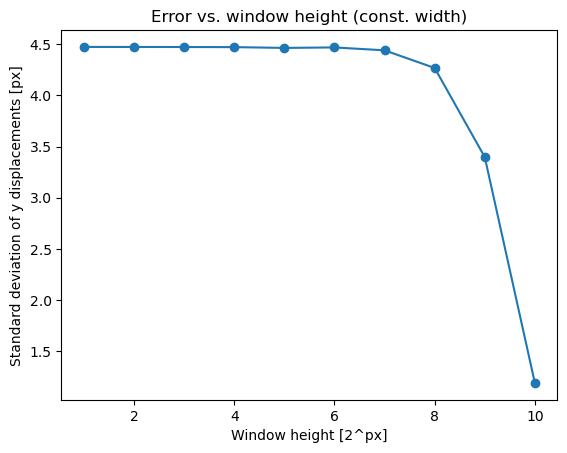

In [6]:
window_size_array = [1024, 512, 256, 128, 64, 32, 16, 8, 4, 2]

std_y = []
for window_height in window_size_array:
    displ, _ = piv.simple_piv(images, (window_height, 128), plot=False)
    
    # Get the standard deviation of the y displacements
    std_y.append(np.std(displ[:,:,1]))

# Plot the standard deviation of the y displacements vs the window height in a log-log plot
fig, ax = plt.subplots()
ax.plot(np.log2(window_size_array), std_y, 'o-')
ax.set_xlabel('Window height [2^px]')
ax.set_ylabel('Standard deviation of y displacements [px]')
ax.set_title('Error vs. window height (const. width)')
plt.show()

#### Solid body flow
This flow can be correlated best with square windows of size $64 \times 64$. Smaller windows result in trouble calculating the maximum peak in the correlation; multiple maxima are found, indicating that the displacement is most likely not within the window. This could be solved by implementing more sophisticated methods, such as window shifting.

From the displacement vector scatter plot, the rotation of the flow could be accurately determined by looking at the angles of the lines in the plot (like in assignment 2). 

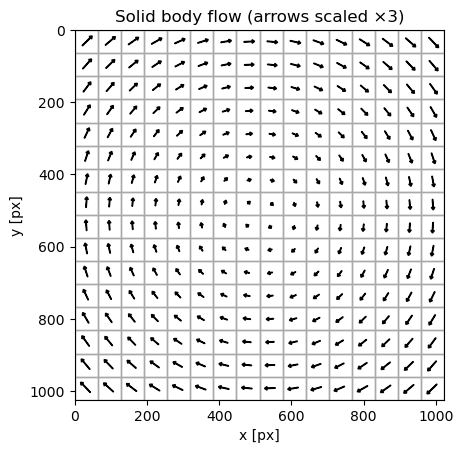

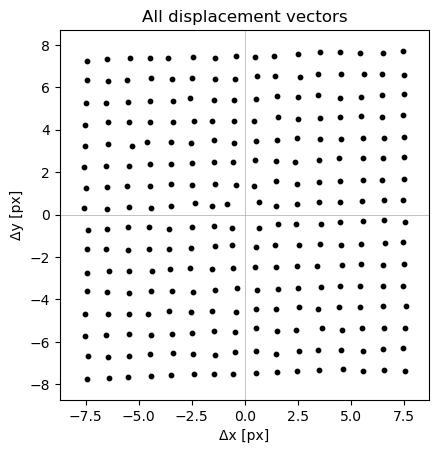

In [7]:
images = piv.read_image_directory('PIVimages/solidbody/')
plot_params = {'arrow_scale':  3,
               'arrow_color':  'k',
               'plot_windows': True,
               'title':        'Solid body flow'}

displacements, coordinates = piv.simple_piv(images, 64, plot=True,
                                            plt_flow_params=plot_params,
                                            plt_disp_params=plot_params)


#### Strange flow
This flow has very small displacements, so a $16 \times 16$ window is the most precise choice that does not result in the "multiple maxima" error. Below, we have highlighted displacements larger than $0.01$ pixels in blue, a function that could be later used to filter outliers. Here, its main purpose is speeding up the visualisation, because the arrows with negligible displacements can be plotted all at once as dots.

From the displacements plot, it also becomes clear that most arrows are bunched together around a $45^\circ$ angle, leading us to suspect that the lonely points are errors.

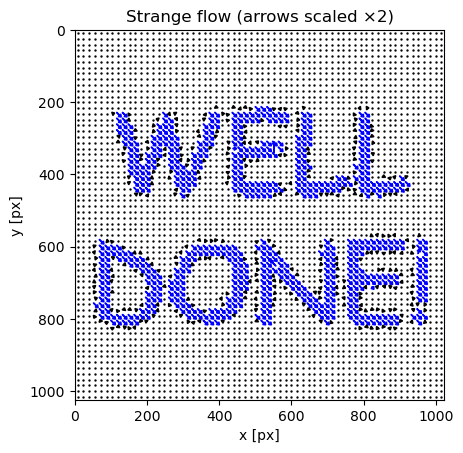

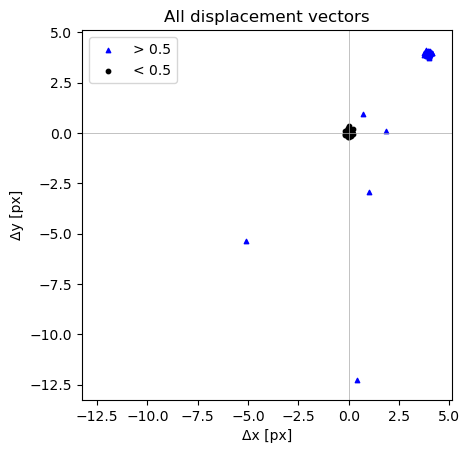

In [8]:
images = piv.read_image_directory('PIVimages/strangeflow/')
plot_params = {'arrow_scale':  2,
               'zero_displ_thr': 0.01,  
               'plot_windows': False,
               'highlight_radius_range': [0.5, np.inf],
               'title':        'Strange flow',
               'legend':       ['> 0.5', '< 0.5']}

displacements, coordinates = piv.simple_piv(images, 16, plot=True,
                                            plt_flow_params=plot_params,
                                            plt_disp_params=plot_params)

#### Commercial flow
The final example also works best with a $16 \times 16$ interrogation window, and shows a very nice logo.

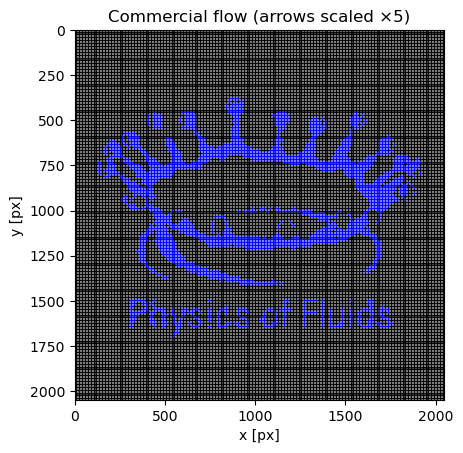

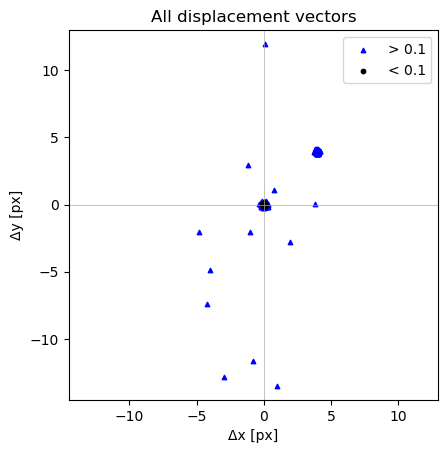

In [9]:
images = piv.read_image_directory('PIVimages/commercialflow/')
plot_params = {'arrow_scale':            5,
               'plot_windows':           False,
               'zero_displ_thr':         100,
               'highlight_radius_range': [0.1, np.inf],
               'title':                  'Commercial flow',
               'legend':                 ['> 0.1', '< 0.1']}

displacements, coordinates = piv.simple_piv(images, 16, plot=True, plt_flow_params=plot_params,plt_disp_params=plot_params)

### b3) **Tracer density & shift** (1.5 pts)

#### Tracer density
We now analyse a set of images with varying tracer density.

In [10]:
images_sets, set_names = piv.read_image_sets('PIVimages/tracerDensity/', grouping_ab=True)
window_size_array = [1024, 512, 256, 128, 64, 32, 16]

# Swap images 2 and 3
images_sets[2], images_sets[3] = images_sets[3], images_sets[2]
set_names[2], set_names[3] = set_names[3], set_names[2]

100%|██████████| 11/11 [00:19<00:00,  1.74s/it]


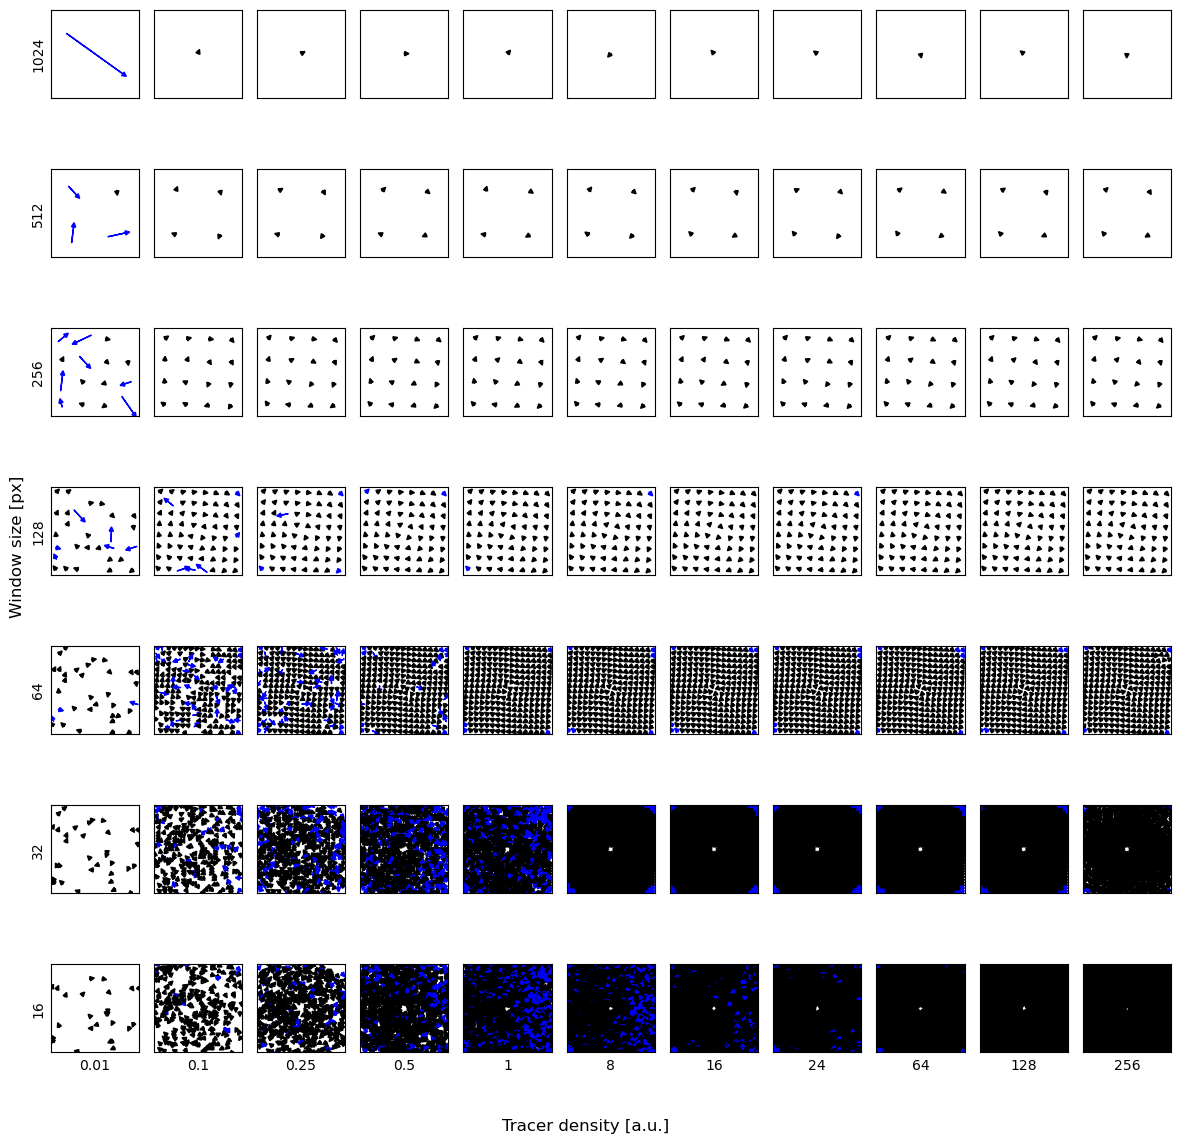

In [11]:
k_max = len(images_sets)
l_max = len(window_size_array)

fig, ax = plt.subplots(l_max, k_max, figsize=(12, 12))

nan_count = np.empty([k_max, l_max])
err_count = np.empty([k_max, l_max])

for k in trange(k_max):
    for l in range(l_max):
        window_size = [window_size_array[l], window_size_array[l]]
        displacements, coordinates = piv.simple_piv(images_sets[k], window_size, skip_errors=True)
        
        # Count the number of nans in the displacements
        nan_count[k, l] = np.sum(np.isnan(displacements))
        
        # Count the number of errors
        err_count[k, l] = np.sum(np.linalg.norm(displacements, axis=2) > 10)
        
        # Plot the flow field window by window
        for j in range(coordinates.shape[0]):
            for i in range(coordinates.shape[1]):

                    # Calculate the start and end of the arrow
                    arrow_start = np.array(
                            [coordinates[j, i][0] -
                             0.5 * displacements[j, i][0],
                             coordinates[j, i][1] -
                             0.5 * displacements[j, i][1]])

                    color = 'b' if np.linalg.norm(displacements[j, i]) > 10 else 'k'
                    # Plot the arrow
                    ax[l, k].arrow(arrow_start[1], arrow_start[0],
                             displacements[j, i][1],
                             displacements[j, i][0],
                             width=1.5,
                             head_width=50,
                             head_length=50,
                             fc=color, ec=color, lw=1)

        # Aspect ratio should be 1
        ax[l, k].set_aspect('equal')

        # Set limits
        ax[l, k].set_xlim([0, np.max(coordinates[:, :, 1]) + window_size[1] / 2])
        ax[l, k].set_ylim([np.max(coordinates[:, :, 0] + window_size[0] / 2), 0])

        # Remove ticks
        ax[l, k].set_xticks([])
        ax[l, k].set_yticks([])

        # For top row, add window size
        if l == l_max-1:
            ax[l, k].set_xlabel(f'{set_names[k]}')

        # For left column, add tracer density
        if k == 0:
            ax[l, k].set_ylabel(f'{window_size[0]}')

fig.supxlabel('Tracer density [a.u.]')
fig.supylabel('Window size [px]')
plt.tight_layout()    
plt.show()

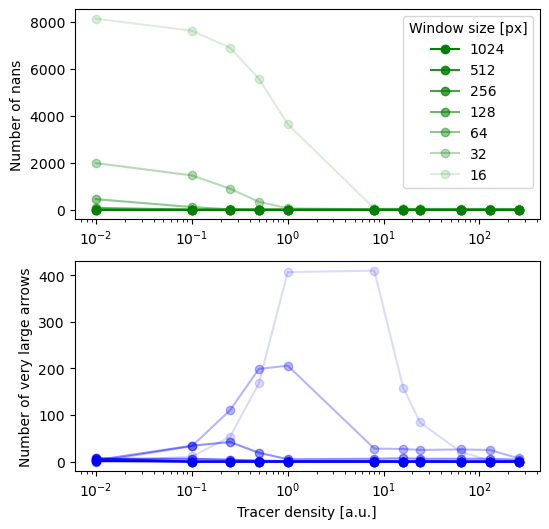

In [12]:
# Plot the nan and error counts as a function of the tracer density, where the window size determines the color of the plot
fig, ax = plt.subplots(2,1, figsize=(6, 6))
tracer_densities = [float(i) for i in set_names]

# For all window sizes
for l in range(l_max):
    ax[0].semilogx(tracer_densities, nan_count[:, l], 'o-', color='g', alpha=(l_max-l)/(l_max), label=f'{window_size_array[l]}')
    
    ax[1].semilogx(tracer_densities, err_count[:, l], 'o-', color='b', alpha=(l_max-l)/(l_max), label=f'{window_size_array[l]}')
ax[1].set_xlabel('Tracer density [a.u.]')
ax[0].set_ylabel('Number of nans')
ax[1].set_ylabel('Number of very large arrows')
ax[0].legend(title='Window size [px]', loc='upper right')

plt.show()

The plot shows that the minimum window size required to avoid errors in the PIV code (as visualised using the number of nans when the `skip_errors` parameter is set to `True`) decreases with the tracer density. This is expected, as the higher the tracer density, the more likely it is that multiple particles are present in the window, leading to multiple maxima in the correlation.

The errors in the PIV code could stem from multiple sources: all pixels might be zero or multiple maximum pixel intensities could be found within the window. The subpixel refinement simply outputs the original pixel-precision value when it encounters a situation it cannot handle (i.e. pixel intensities of zero or a maximum at the edge of the window). 

#### Tracer displacement
A similar analysis can be performed for varying particle shifts.

In [13]:
images_sets, set_names = piv.read_image_sets('PIVimages/tracerDisplacement/', grouping_ab=True)

# Remove wrong reading
images_sets[3] = images_sets[3][0:2]
# Swap images 1 and 2
images_sets[1], images_sets[2] = images_sets[2], images_sets[2]
set_names[1], set_names[2] = set_names[2], set_names[1]
window_size_array = [128, 64, 32, 16, 8, 4, 2]

k_max = len(images_sets)
l_max = len(window_size_array)

In [14]:
nan_count = np.empty([k_max, l_max])

for k in trange(k_max):
    for l in range(l_max):
        window_size = [window_size_array[l], window_size_array[l]]
        displacements, _ = piv.simple_piv(images_sets[k], window_size, skip_errors=True)
        
        # Count the number of nans in the displacements
        nan_count[k, l] = np.sum(np.isnan(displacements))

100%|██████████| 10/10 [01:41<00:00, 10.13s/it]


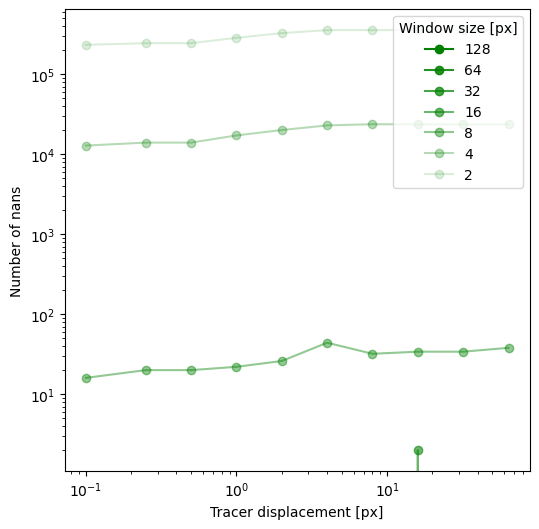

In [15]:
# Plot the nan and error counts as a function of the tracer density, where the window size determines the color of the plot
fig, ax = plt.subplots(1,1, figsize=(6, 6))
tracer_displacements = [float(i) for i in set_names]

# For all window sizes
for l in range(l_max):
    ax.loglog(tracer_displacements, nan_count[:, l], 'o-', color='g', alpha=(l_max-l)/(l_max), label=f'{window_size_array[l]}')
    
ax.set_xlabel('Tracer displacement [px]')
ax.set_ylabel('Number of nans')
ax.legend(title='Window size [px]', loc='upper right')

plt.show()

Here, it is clear that the tracer displacement only becomes a problem for very small window sizes. For these cases, the number of errors increases for larger displacements. This makes sense, because the particles might have left the window already in the time between the frames. One could solve this by choosing wider windows in the direction of flow, performing window shifting, or averaging the flow when it is homogeneous in one direction, for example.  

### b4) **Suboptimal images** (1.5 pts)

#### Leaky particles
Let us consider some images where particles float in and out of the image domain. First, we take a small window size of $25 \times 25$ pixels.

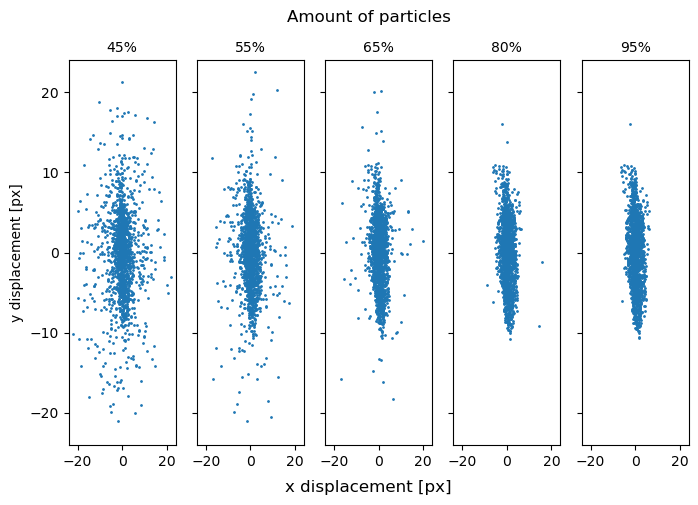

In [20]:
images_sets, set_names = piv.read_image_sets('PIVimages/Suboptimal/', 'LeakyParticles', grouping_ab=True)

fig, ax = plt.subplots(1, len(images_sets), figsize=(8, 5))

for i in range(len(images_sets)):
    
    displacements, _ = piv.simple_piv(images_sets[i], 25, plot=False)
    
    # Plot the displacement vectors
    ax[i].scatter(displacements[:,:,1].flatten(), displacements[:,:,0].flatten(), s=1)
    ax[i].set_title(f'{set_names[i]}%', fontsize=10)
    ax[i].set_xlim([-24, 24])
    ax[i].set_ylim([-24, 24])
    
    if i == 0:
        ax[i].set_ylabel('y displacement [px]')
    else:
        ax[i].set_yticklabels([])
    
fig.supxlabel('x displacement [px]')
fig.suptitle('Amount of particles')
plt.show()

We would expect that, when the largest percentage of particles is present, we get the most accuracte visualisation of the flow. In this case, the 95% plot on the right would be closest to reality. Clearly, when less particles are present, the small window size of $25 \times 25$ pixels is not sufficient to capture the flow, resulting in larger displacement vectors. The difference in flow fields is shown below.

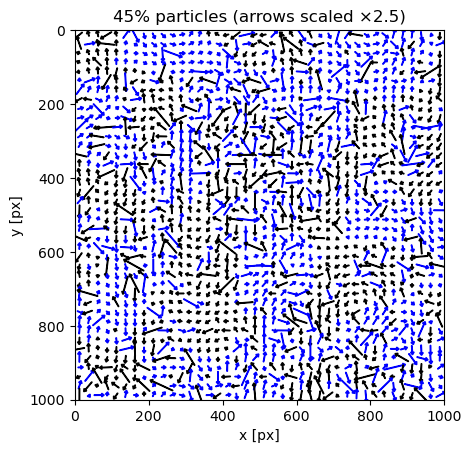

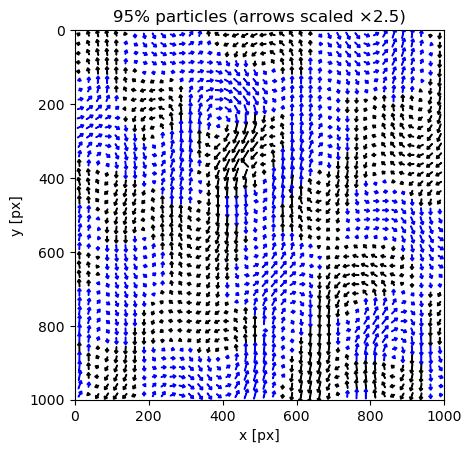

In [21]:
plot_params = {'arrow_scale':            2.5,
               'plot_windows':           False,
               'highlight_angle_range':  [0, np.pi]}

displacements, coordinates = piv.simple_piv(images_sets[0], 25, plot=False)
_,_ = piv.plot_flow_field(displacements, coordinates, 25, title='45% particles', **plot_params)

displacements, coordinates = piv.simple_piv(images_sets[4], 25, plot=False)
_,_ = piv.plot_flow_field(displacements, coordinates, 25, title='95% particles', **plot_params)

This problem disappears when increasing the window size. However, that comes with a trade-off of losing out on information density, as illustrated below.

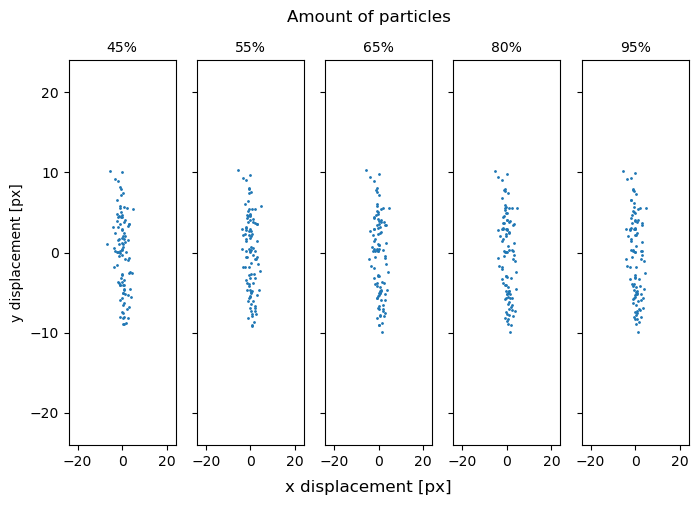

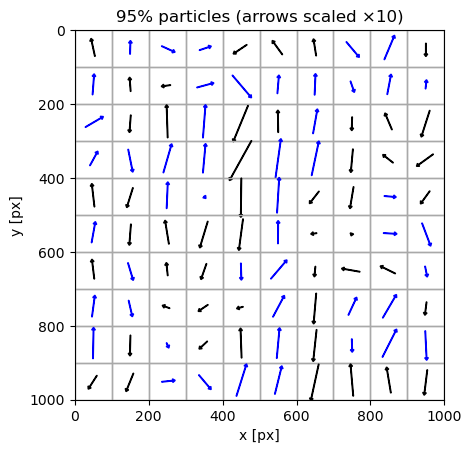

In [22]:
fig, ax = plt.subplots(1, len(images_sets), figsize=(8, 5))

for i in range(len(images_sets)):
    
    displacements, _ = piv.simple_piv(images_sets[i], 100, plot=False)
    
    # Plot the displacement vectors
    ax[i].scatter(displacements[:,:,1].flatten(), displacements[:,:,0].flatten(), s=1)
    ax[i].set_title(f'{set_names[i]}%', fontsize=10)
    ax[i].set_xlim([-24, 24])
    ax[i].set_ylim([-24, 24])
    
    if i == 0:
        ax[i].set_ylabel('y displacement [px]')
    else:
        ax[i].set_yticklabels([])
    
fig.supxlabel('x displacement [px]')
fig.suptitle('Amount of particles')
plt.show()

displacements, coordinates = piv.simple_piv(images_sets[4], 100, plot=False)
_,_ = piv.plot_flow_field(displacements, coordinates, 100, title='95% particles', arrow_scale=10, 
               highlight_angle_range=[0, np.pi])

#### Uneven lighting
Unlike in the particle tracking assignment, uneven lighting should not pose a problem for PIV analysis, since the cross-correlation is calculated over a small window.

The resulting displacement field is shown below; no errors are encountered.

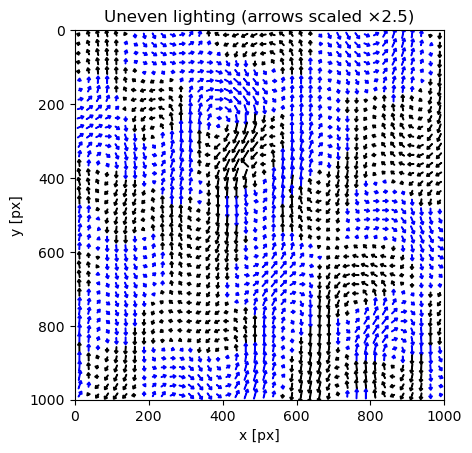

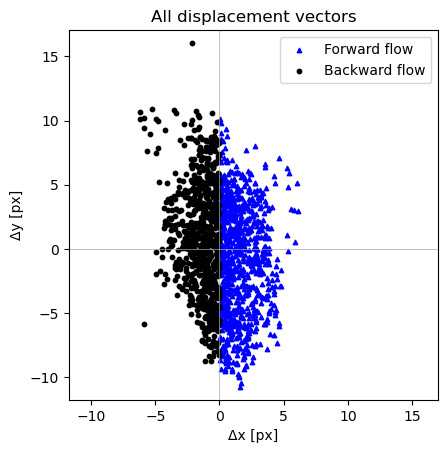

In [23]:
images_sets, set_names = piv.read_image_sets('PIVimages/Suboptimal/', 'UnevenLighting', grouping_ab=True)

plot_params = {'arrow_scale':            2.5,
               'plot_windows':           False,
               'title':                  'Uneven lighting',
               'highlight_angle_range':  [0, np.pi],
               'legend':                 ['Forward flow', 'Backward flow']}

displacements, coordinates = piv.simple_piv(images_sets[0], 25, plot=True, plt_flow_params=plot_params, plt_disp_params=plot_params)

### b5) **Advanced functions** (3 bonus pts)
Let us briefly consider two sample images of our final assignment, which involves PIV of smoke in the channel of the cough machine in ME 206. From a rough calibration, we already know that 200 pixels correspond to a distance of 3 cm.

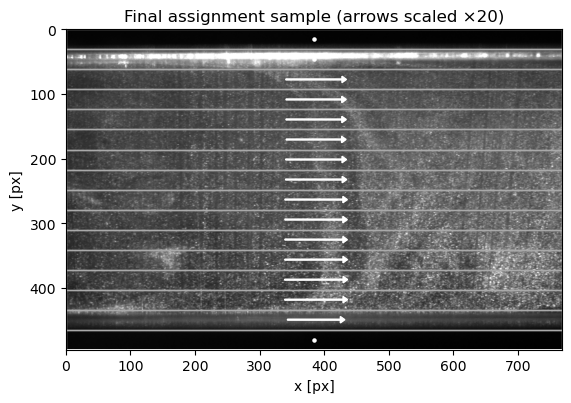

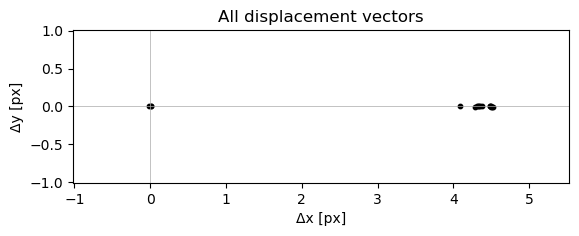

In [6]:
# Load the example images of the final assignment
images = piv.read_image_directory('PIVimages_final/', '240404', image_type='tif')

plot_params = {'arrow_scale':            20,
               'plot_windows':           True,
               'title':                  'Final assignment sample',
               'background':             images[0],
               'arrow_color':            'white',
               'zero_displ_thr':         0.1}

# Try simple PIV
displacements, coordinates = piv.simple_piv(
        images, (31,768),
        plot=True, plt_flow_params=plot_params, plt_disp_params=plot_params)

Time's up; to be continued in the final assignment...

### **Appendix**
#### File handling functions

In [ ]:
import os
from natsort import natsorted
from natsort import index_natsorted
import cv2 as cv
import numpy as np


def read_image_directory(directory, prefix=None, image_type='png'):
    """
    Read all images in a directory and store them in a 3D array.

    PARAMETERS:
        directory (str): Path to the directory containing the images.
        prefix (str): Prefix of the image files to read.
        image_type (str): Type of the image files to read.

    RETURNS:
        images (np.array): array (i, y, x) containing the images.
    """

    # Get a list of files in the directory
    files = os.listdir(directory)

    # If a prefix is specified, filter the list of files
    if prefix is not None:
        files = [f for f in files if f.startswith(prefix)]

    # If a type is specified, filter the list of files
    if image_type is not None:
        files = [f for f in files if f.endswith(image_type)]

    # Sort the files
    files = natsorted(files)

    # Read the images and store them in a 3D array
    images = np.array([cv.imread(os.path.join(directory, f),
                                 cv.IMREAD_GRAYSCALE) for f in files],
                      dtype=np.uint64)

    return images


def read_image_sets(directory, prefix=None, image_type='png', grouping_ab=False):
    """
    Read sets of images in subdirectories and store them in a list of 3D arrays.

    PARAMETERS:
        directory (str): Path to the directory containing the image sets.
        prefix (str): Prefix of the image files to read.
        image_type (str): Type of the image files to read.

    RETURNS:
        image_sets (list): List of arrays (i, y, x) containing the image sets.
        set_names (list): List of strings containing subdirectory names.
    """

    # Initialize lists to store the image sets and their names
    images_sets = []
    set_names = []

    # Walk through the directory and its subdirectories
    for subdirectory, _, files in os.walk(directory):

        # Skip empty directories
        if len(files) < 2:
            continue

        # If a prefix is specified, filter the list of files
        if prefix is not None:
            files = [f for f in files if f.startswith(prefix)]

        # If specified, group files with common base names
        if grouping_ab & (len(files) > 2):

            # files = os.listdir(subdirectory)

            # Go through all files
            for file in files:
                # Get any files that have the same base name apart from the
                # character a or b at the end
                base_name = file.rstrip('ab.' + image_type)

                # If the base name is not in the list of set names...
                if base_name not in set_names:

                    # ...import the images
                    images = read_image_directory(directory, base_name,
                                                  image_type)
                    images_sets.append(images)

                    # Save the set name
                    set_names.append(base_name)

        else:
            # Read the images in the subdirectory
            images = read_image_directory(subdirectory, prefix, image_type=image_type)
            images_sets.append(images)

            # Save the subdirectory name
            set_names.append(subdirectory.split('/')[-1])

    # Look for any strings that exist within all set names
    common_str = os.path.commonprefix(set_names)

    # If a common string was found, remove it from the set names
    if common_str:
        set_names = [name.replace(common_str, '') for name in set_names]

    # Remove trailing underscores from the set names
    set_names = [name.rstrip('_') for name in set_names]

    # Naturally sort the set names and images by the set names
    sort_order = index_natsorted(set_names)
    image_sets = [images_sets[i] for i in sort_order]
    set_names = natsorted(set_names)

    return image_sets, set_names


#### Helper functions

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal as sig


def correlate_image_pair(image0, image1, method='correlate', plot=False):
    """
    Calculate the cross-correlation between two images.

    PARAMETERS:
        image0 (np.array): First image [y, x].
        image1 (np.array): Second image [y, x].
        method (str): Method to use for the cross-correlation.
            Options are 'correlate' and 'convolve'.
        plot (bool): Whether to plot the images and the correlation.

    RETURNS:
        correlation (np.array): Cross-correlation [y, x] between the two images.
    """

    # Compute the correlation between the two images using two methods
    if method == 'correlate':
        correlation = sig.correlate(image1, image0)
    elif method == 'convolve':
        correlation = sig.fftconvolve(image1, image0[::-1, ::-1])
    else:
        raise ValueError('Invalid method')

    # If the plot option was set...
    if plot:
        # Plot the frames
        fig, ax = plt.subplots(1, 2, figsize=(6, 3))
        ax[0].imshow(image0, cmap='gray')
        ax[0].set_title('Frame 0')
        ax[0].set_xlabel('y [px]')
        ax[0].set_ylabel('x [px]')

        ax[1].imshow(image1, cmap='gray')
        ax[1].set_title('Frame 1')
        ax[1].set_xlabel('y [px]')
        ax[1].set_yticklabels([])
        plt.show()

        # Plot the correlation
        ax_extent = [-image0.shape[1] + 0.5, image0.shape[1] - 0.5,
                     -image0.shape[0] + 0.5, image0.shape[0] - 0.5]
        ax_ticks = np.round(np.array(ax_extent) / 10) * 10

        fig, ax = plt.subplots(1, 1, figsize=(6, 6))
        ax.imshow(correlation, cmap='gray', interpolation='none',
                  extent=ax_extent)
        ax.set_xticks(np.arange(ax_ticks[0], ax_ticks[1] + 1, 10))
        ax.set_yticks(np.arange(ax_ticks[2], ax_ticks[3] + 1, 10))
        ax.set_title('Correlation')
        ax.set_xlabel('dy [px]')
        ax.set_ylabel('dx [px]')
        plt.show()

    return correlation


def find_displacement(correlation, subpixel_method='gauss_neighbor',
                      skip_errors=False):
    """
    Find the displacement peak in a cross-correlation array.

    PARAMETERS:
        correlation (np.array): Cross-correlation array [y, x].
        subpixel_method (str): Method to use for subpixel refinement.
            Options are 'gauss_neighbor'.
        skip_errors (bool): Whether to skip errors in subpixel refinement.

    RETURNS:
        displacement (np.array): Displacement vector [y, x].
    """

    # If all values in the correlation array are zero...
    if np.all(correlation == 0):
        # Return a nan displacement
        return np.array([np.nan, np.nan])

    # Calculate the peak value indices of the cross-correlation
    peak = np.argwhere(np.amax(correlation) == correlation)

    # If multiple maxima were found...
    if len(peak) > 1:
        # Error
        if skip_errors:
            return [np.nan, np.nan]
        else:
            raise ValueError('Multiple equal maxima found in cross-correlation')
    else:
        # Take the first value if only one peak was found
        peak = peak[0]

    # If the subpixel option was set...
    if subpixel_method is not None:
        # Try refining the peak location
        try:
            correction = subpixel_refinement(correlation, peak, subpixel_method)

        # If this gives an error, continue without refinement or throw an error
        except ValueError as e:
            if skip_errors:
                correction = np.zeros((2,))
            else:
                raise e

        peak = peak + np.array(correction)

    # Subtract the image center to get relative coordinates
    image_centre = (np.array(correlation.shape - np.ones_like((1, 2))) / 2)
    displacement = peak - image_centre

    return displacement


def intensity_at_peak(correlation, displacement):
    """
    Get the intensity at the peak of a cross-correlation array.

    PARAMETERS:
        correlation (np.array): Cross-correlation array [y, x].
        displacement (np.array): Displacement vector [y, x].

    RETURNS:
        intensity (float): Intensity at the peak of the cross-correlation.
    """

    # Convert the peak values back to indices
    image_centre = (np.array(correlation.shape - np.ones_like((1, 2))) / 2)
    peak = displacement + image_centre

    # Get the intensity at the peak indices
    intensity = correlation[int(peak[0]), int(peak[1])]

    return intensity


def subpixel_refinement(correlation, peak, method='gauss_neighbor'):
    """
    Refine the peak location in a cross-correlation array to subpixel precision.

    PARAMETERS:
        correlation (np.array): Cross-correlation array [y, x].
        peak (np.array): Peak location [y, x].
        method (str): Method to use for subpixel refinement.
    """

    # Three-point offset calculation from the lecture
    if method == 'gauss_neighbor':

        # Get the neighbouring pixels in both dimensions
        neighbors = [correlation[(peak[0] - 1):(peak[0] + 2), peak[1]],
                     correlation[peak[0], (peak[1] - 1):(peak[1] + 2)]]

        # If any of the neighbors are zero
        if np.any([np.any(neighbor == 0) for neighbor in neighbors]):
            raise ValueError(
                    'Zero intensity pixels do not allow for Gaussian neighbor interpolation.')

        # If the neighbors shape is not 3x3...
        if not all([neighbor.shape == (3,) for neighbor in neighbors]):
            raise ValueError(
                    'Tried to calculate a maximum at the edge of the window.')

        # Three-point Gaussian fit in both dimensions
        correction = [(0.5 * (np.log(neighbor[0]) - np.log(neighbor[2]))
                       / ((np.log(neighbor[0])) + np.log(neighbor[2]) -
                          2 * np.log(neighbor[1]))) for neighbor in neighbors]

    else:
        raise ValueError('Invalid method')

    return correction


def assume_squareness(size):
    """
    Assume that a window size is square, even if only one dimension is given.

    PARAMETERS:
        size (int or tuple): Size of a window in pixels. If an integer is
            supplied, the function turns this into a square window.

    RETURNS:
        size (np.array): Size of a window in pixels, as a 1D, 2-element array.
    """

    # Turn int or tuple into 1D array
    size = np.array([size]).flatten()

    # If the array has more than two elements, raise an error
    if size.size > 2:
        raise ValueError('The size should be a 1D array with 1 or 2 elements.')

    # If the size is a single element, assume a square window
    if len(size) == 1:
        size = np.array([size[0], size[0]])

    return size


def divide_in_windows(images, window_size):
    """
    Divide a set of images into windows of a given (equal!) size.

    PARAMETERS:
        images (np.array): Images [c, y, x].
        window_size (int or tuple): Size of a window in pixels.

    RETURNS:
        windows (np.array): Windows [c, j, i, j_y, i_x].
        coordinates (np.array): Coordinates of the centre of each window [y, x].
    """

    # Process window_size, which may be an integer or tuple
    window_size = assume_squareness(window_size)

    # Check whether one or multiple images was supplied
    if len(images.shape) == 2:
        # If only one image was supplied, add a dimension
        images = images[np.newaxis, :, :]

    # Check whether the images can be evenly divided into windows of this size
    if not np.all([np.mod(images.shape[j + 1], window_size[j]) == 0 for j in
                   range(len(images.shape) - 1)]):
        # Error
        raise ValueError(
                f'A {window_size} window does not fit into the images.')

    # Get the coordinates of the top left pixel of each window
    coordinates = np.array(
            [[[y, x] for x in range(0, images.shape[2], window_size[1])] for y
             in range(0, images.shape[1], window_size[0])])

    # Get the coordinates of the centre of each window
    coordinates = coordinates + np.array(window_size) / 2

    # Divide the images into windows of size window_size
    windows = np.array(
            [[[images[z, y:(y + window_size[0]), x:(x + window_size[1])]
               for x in range(0, images.shape[2], window_size[1])] for y in
              range(0, images.shape[1], window_size[0])] for z in
             range(images.shape[0])])

    return windows, coordinates


def filter_displacements(displacements, radius_range=None,
                         angle_range=None, template=None):
    """
    Filter out displacement vectors based on their magnitude and angle.

    PARAMETERS:
        displacements (np.array): Displacement vectors [j, i, y/x].
        radius_range (list): Range of magnitudes to keep.
        angle_range (list): Range of angles to keep.
        template (np.array): Template to use for filtering.

    RETURNS:
        mask (np.array): Boolean mask [j, i] of the filtered vectors.
    """

    # MODE 1: Polar coordinates
    if template is None:
        # Set default values
        if angle_range is None:
            angle_range = [-np.pi, np.pi]
        if radius_range is None:
            radius_range = [0, np.inf]

        # Calculate the magnitude and angle of the displacement vectors
        magnitudes = np.linalg.norm(displacements, axis=2)
        angles = np.arctan2(displacements[:, :, 1], displacements[:, :, 0])

        # If only nans are given, skip the filtering
        if np.all(np.isnan(radius_range + angle_range)):
            mask = np.zeros(displacements.shape[:2], dtype=bool)

        # Filter the displacements based on the given radius and angle ranges
        else:
            # Create a mask the same size as displacements
            mask = np.ones(displacements.shape[:2], dtype=bool)

            if not np.isnan(radius_range[0]):
                mask = mask & (magnitudes > radius_range[0])
            if not np.isnan(radius_range[1]):
                mask = mask & (magnitudes < radius_range[1])
            if not np.isnan(angle_range[0]):
                mask = mask & (angles > angle_range[0])
            if not np.isnan(angle_range[1]):
                mask = mask & (angles < angle_range[1])

        # Return the mask
        return mask

    # MODE 2: Template-based filtering
    else:
        raise NotImplementedError('Template-based filtering is not implemented')
        # TODO: Implement template-based filtering


def remove_outliers(displacements, mask, windows, method='nan'):
    if method == 'nan':
        # Set the outliers to NaN
        displacements[~mask] = np.nan
    elif method == 'mean':
        # Set the outliers to the mean of the surrounding values
        raise NotImplementedError(
                'Mean-based outlier removal is not implemented')
        # TODO: Implement mean-based outlier removal

    return displacements


def shift_windows():
    pass


def merge_windows():
    pass


#### PIV function

In [ ]:
from pof_piv.helper_functions import *
from pof_piv.plot_functions import *
import numpy as np


def simple_piv(images, window_size, calib_dist=None, calib_time=None,
               subpixel_method='gauss_neighbor', skip_errors=False,
               plot=False, plt_flow_params={}, plt_disp_params={}):
    """
    Perform a basic PIV analysis on two images.

    This function takes in two images and calculates the displacement of
    windows in the first image with respect to the second image. The
    displacement is calculated using the correlation between the two images
    and the subpixel method specified.

    PARAMETERS:
        images (np.array): Two images [c, y, x].
        window_size (int | tuple): Size of the windows [y, x].
        calib_dist (float): Calibration distance.
        calib_time (float): Time between the two images.
        subpixel_method (str): Subpixel method to use.
            Options are 'gauss_neighbor'.
        plot (bool): Whether to plot the flow field and displacements.
        plt_flow_params (dict): Parameters for the flow field plot.
        plt_disp_params (dict): Parameters for the displacements plot.

    RETURNS:
        velocities or displacements (np.array): Velocity or displacement
            vectors [j, i, y/x], depending on whether calibration data was
            supplied.
        coordinates (np.array): Coordinates of the windows [j, i, y/x].
    """

    # Check whether there is two or more images
    if images.shape[0] < 2:
        # Error
        raise ValueError('At least two images are required for PIV.')
    elif images.shape[0] > 2:
        # Warning
        raise NotImplementedError('Only two images are currently supported.')

    # Divide the images into windows
    windows, coordinates = divide_in_windows(images, window_size)

    # Calculate the correlation of each window [j, i] in frame 0 with the
    # corresponding window in frame 1
    correlations = np.array([[correlate_image_pair(windows[0, j, i],
                                                   windows[1, j, i], plot=False)
                              for i in range(windows.shape[2])]
                             for j in range(windows.shape[1])])

    # Calculate the displacement of each window [j, i] in frame 0 with the
    # corresponding window in frame 1
    displacements = np.array(
            [[find_displacement(correlation,
                                subpixel_method=subpixel_method,
                                skip_errors=skip_errors) for correlation in row]
             for row in correlations])

    if plot:
        # Plot the flow field
        plot_flow_field(displacements, coordinates, window_size,
                        **plt_flow_params)

        # Plot the displacements
        plot_displacements(displacements, **plt_disp_params)
        pass

    # Calculate the velocity field
    if calib_dist is not None and calib_time is not None:
        # Calibrate the displacement vectors
        displacements_calibrated = displacements * calib_dist

        # Calculate the velocity vectors
        velocities = displacements_calibrated / calib_time

        return velocities, coordinates
    else:
        return displacements, coordinates


#### Plot functions

In [ ]:
from pof_piv.helper_functions import filter_displacements, assume_squareness
import numpy as np
from matplotlib import pyplot as plt
from tqdm import trange


def plot_flow_field(displacements, coordinates, window_size,
                    background=None, plot_windows=True,
                    arrow_color='k', arrow_scale=1, zero_displ_thr=0,
                    highlight_radius_range=None,
                    highlight_angle_range=None,
                    highlight_color='b', calib_dist=None, units=None,
                    title='Flow field', legend=None, timing=False):
    """
    Plot the flow field with displacements as arrows.

    This function takes in the same keyword arguments as plot_displacements,
    but ignores some of them.

    PARAMETERS:
        displacements (np.array): Displacement vectors [j, i, y/x].
        coordinates (np.array): Coordinates of the windows [j, i, y/x].
        window_size (int | tuple): Size of the windows [y, x].
        background (np.array): Background image to plot the flow field on.
        plot_windows (bool): Whether to plot the windows.
        arrow_color (str): Color of the arrows.
        arrow_scale (float): Scale of the arrows.
        zero_displ_thr (float): Threshold for displacements to be plotted
            as dots.
        highlight_radius_range (list): Range of magnitudes to highlight.
        highlight_angle_range (list): Range of angles to highlight.
        highlight_color (str): Color of the highlighted arrows and dots.
        calib_dist (float): Calibration distance.
        units (str): Units of the calibration distance.
        title (str): Title of the plot.
        legend (list): Unused.
        timing (bool): Whether to show a progress bar.

    RETURNS:
        fig (plt.figure): Figure object.
        ax (plt.axis): Axis object.
    """

    # Assume the window size is square
    if highlight_angle_range is None:
        highlight_angle_range = [np.nan, np.nan]
    if highlight_radius_range is None:
        highlight_radius_range = [np.nan, np.nan]
    window_size = assume_squareness(window_size)

    # Plot all displacement vectors at the center of each window
    fig, ax = plt.subplots()

    # If a background image is supplied, add it to the plot
    if background is not None:
        ax.imshow(background, cmap='gray')

    # If a calibration distance was specified, calibrate all values
    if calib_dist is not None:
        displacements = displacements * calib_dist
        coordinates = coordinates * calib_dist
        window_size = window_size * calib_dist

    # Show a grid with the outline of each window and an arrow in the centre
    # indicating the displacement
    arrow_param = calib_dist if calib_dist is not None else 1

    # Get a list of indices that should be coloured
    highlight = filter_displacements(displacements,
                                     radius_range=highlight_radius_range,
                                     angle_range=highlight_angle_range)

    # Get a list of indices that are below the zero-threshold
    zero_displ = np.linalg.norm(displacements, axis=2) < zero_displ_thr

    # Plot the indices below the threshold as dots
    ax.scatter(coordinates[zero_displ & highlight, 1],
               coordinates[zero_displ & highlight, 0],
               c=highlight_color, marker='.', s=arrow_scale)
    ax.scatter(coordinates[zero_displ & ~highlight, 1],
               coordinates[zero_displ & ~highlight, 0],
               c=arrow_color, marker='.', s=arrow_scale)

    # Plot the flow field window by window
    for j in trange(coordinates.shape[0], desc='Plotting arrows',
                    disable=not timing):
        for i in range(coordinates.shape[1]):

            # Plot the window
            if plot_windows:
                ax.add_patch(
                        plt.Rectangle(
                                (coordinates[j, i][1] - window_size[1] / 2,
                                 coordinates[j, i][0] - window_size[0] / 2),
                                window_size[1],
                                window_size[0], fill=None,
                                edgecolor='darkgrey',
                                linewidth=1))

            # If the displacement is above the zero-threshold, plot an arrow
            if np.linalg.norm(displacements[j, i]) > zero_displ_thr:
                # If the displacement should be highlighted, set the color
                color = highlight_color if highlight[j, i] else arrow_color

                # Calculate the start and end of the arrow
                arrow_start = np.array(
                        [coordinates[j, i][0] -
                         arrow_scale * 0.5 * displacements[j, i][0],
                         coordinates[j, i][1] -
                         arrow_scale * 0.5 * displacements[j, i][1]])

                # Plot the arrow
                ax.arrow(arrow_start[1], arrow_start[0],
                         arrow_scale * displacements[j, i][1],
                         arrow_scale * displacements[j, i][0],
                         width=1.5 * arrow_param,
                         head_width=10 * arrow_param,
                         head_length=7 * arrow_param,
                         fc=color, ec=color, lw=1)

    # Aspect ratio should be 1
    ax.set_aspect('equal')

    # Set limits
    ax.set_xlim([0, np.max(coordinates[:, :, 1]) + window_size[1] / 2])
    ax.set_ylim([np.max(coordinates[:, :, 0] + window_size[0] / 2), 0])

    # If a calibration distance was specified, add units to the labels
    if calib_dist is not None:
        ax.set_xlabel(f'x [{units}]')
        ax.set_ylabel(f'y [{units}]')
    else:
        ax.set_xlabel('x [px]')
        ax.set_ylabel('y [px]')

    # If an arrow scale was specified, add it to the title
    if arrow_scale != 1:
        title = title + f' (arrows scaled ×{arrow_scale})'
    ax.set_title(title)
    plt.show()

    return fig, ax


def plot_displacements(displacements,
                       background=None, plot_windows=True,
                       arrow_color='k', arrow_scale=1, zero_displ_thr=0,
                       highlight_radius_range=None,
                       highlight_angle_range=None,
                       highlight_color='b', calib_dist=None, units=None,
                       title=None, legend=None,
                       timing=False):
    """
    Plot the displacement vectors.

    This function takes in the same keyword arguments as plot_flow_field,
    but ignores some of them.

    PARAMETERS:
        displacements (np.array): Displacement vectors [j, i, y/x].
        background (np.array): Unused.
        plot_windows (bool): Unused.
        arrow_color (str): Unused.
        arrow_scale (float): Unused.
        zero_displ_thr (float): Unused.
        highlight_radius_range (list): Range of magnitudes to highlight.
        highlight_angle_range (list): Range of angles to highlight.
        highlight_color (str): Color of the highlighted arrows and dots.
        calib_dist (float): Calibration distance.
        units (str): Units of the calibration distance.
        title (str): Unused.
        legend (list): Legend of the plot.
        timing (bool): Whether to show a progress bar.

    RETURNS:
        fig (plt.figure): Figure object.
        ax (plt.axis): Axis object.
    """

    # Set all default values
    if legend is None:
        legend = ['Highlighted', 'Out of range']
    if highlight_angle_range is None:
        highlight_angle_range = [np.nan, np.nan]
    if highlight_radius_range is None:
        highlight_radius_range = [np.nan, np.nan]

    # Plot all displacement vectors
    fig, ax = plt.subplots()

    # If a calibration distance was specified, calibrate all values
    if calib_dist is not None:
        displacements = displacements * calib_dist

    # Get a list of indices that should be coloured
    highlight = filter_displacements(displacements,
                                     radius_range=highlight_radius_range,
                                     angle_range=highlight_angle_range)

    # Plot the indices below the threshold as dots
    ax.scatter(displacements[highlight, 1], displacements[highlight, 0],
               marker='^', s=10, color=highlight_color)
    ax.scatter(displacements[~highlight, 1], displacements[~highlight, 0],
               marker='o', s=10, color='k')

    # Draw zero lines
    ax.axhline(0, color='darkgrey', lw=0.5)
    ax.axvline(0, color='darkgrey', lw=0.5)

    # Pad the limits, but use only finite values
    displacements_finite = displacements[np.any(np.isfinite(displacements),
                                                axis=2)]
    ax.set_xlim([np.nanmin(displacements_finite[:, 1]) - 1,
                 np.nanmax(displacements_finite[:, 1]) + 1])
    ax.set_ylim([np.nanmin(displacements_finite[:, 0]) - 1,
                 np.nanmax(displacements_finite[:, 0]) + 1])

    # Pad the x limits to make the plot square
    ax.set_xlim([np.amin([ax.get_xlim()[0], ax.get_ylim()[0]]),
                 np.amax([ax.get_xlim()[1], ax.get_ylim()[1]])])

    ax.set_aspect('equal')

    # If a calibration distance was specified, add units to the labels
    if calib_dist is not None:
        ax.set_xlabel(f'Δx [{units}]')
        ax.set_ylabel(f'Δy [{units}]')
    else:
        ax.set_xlabel('Δx [px]')
        ax.set_ylabel('Δy [px]')

    # If points were highlighted, add a legend
    if np.any(highlight):
        ax.legend(legend)

    ax.set_title('All displacement vectors')
    plt.show()

    return fig, ax
